In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'


nprocs = 20

In [3]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [4]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 21374 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 21374 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 21374 tips and 21373 internal nodes ]


In [5]:
%%R
levels(physeq.Bulk.m$Till)

[1] "N" "P"


In [6]:
%%R
get_l2fc = function(physeq.obj, Month, Year, sparsity_threshold) {
    physeq.md = sample_data(physeq.obj)
  
  
    p = prune_samples((physeq.md$Month == Month) &
                      (physeq.md$Year == Year), physeq.obj)
   
    p = filter_taxa(p, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Till)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}

In [73]:
%%R

sdm = physeq.Bulk %>% sample_data %>% 
    filter(! is.na(Till)) %>%
    select(Month, Year) %>%
    distinct() %>%
    arrange(Year, Month) 

sdm %>% nrow %>% print
sdm %>% head(n=5)


[1] 11
      Month Year
1      July 2014
2  November 2014
3   October 2014
4 September 2014
5     April 2015


In [74]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Month, Year, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Month', 'Year'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
head(sdms) 

Number of pairwise combinations of variables: 209 

      Month Year sparsity_threshold
1      July 2014               0.05
2  November 2014               0.05
3   October 2014               0.05
4 September 2014               0.05
5     April 2015               0.05
6    August 2015               0.05


In [75]:
%%R
#For testing method
test = head(sdms, 2)
test

     Month Year sparsity_threshold
1     July 2014               0.05
2 November 2014               0.05


In [76]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [906,740 x 15]

   Month  Year sparsity_threshold       OTU log2FoldChange     lfcSE      padj
   (chr) (chr)              (dbl)     (chr)          (dbl)     (dbl)     (dbl)
1   July  2014               0.05  OTU.4940     -1.7278560 1.4089253 0.8487817
2   July  2014               0.05  OTU.4163      0.6382750 1.4005280 0.8487817
3   July  2014               0.05  OTU.5493      2.5584025 1.4249415 0.6156183
4   July  2014               0.05  OTU.1739      0.2196383 1.1055108 0.9427991
5   July  2014               0.05  OTU.1813     -1.4283116 1.0987975 0.8487817
6   July  2014               0.05   OTU.778     -1.1140509 0.4185279 0.2054489
7   July  2014               0.05  OTU.5511     -0.6601852 1.4290959 0.8487817
8   July  2014               0.05  OTU.6957     -1.4432110 1.4277326 0.8487817
9   July  2014               0.05  OTU.5658      0.1051447 1.4168954 0.9760929
10  July  2014               0.05 OTU.13088     -1.0757677 1.4118314 0.8487817
..   ...   

In [77]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

   meanl2fc
      (dbl)
1 0.1096853


In [78]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 1.267539


In [79]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [80]:
%%R
df.l2fc$Till[df.l2fc$log2FoldChange > 0] = "PT"
df.l2fc$Till[df.l2fc$log2FoldChange <0] = "NT"

In [81]:
%%R
write.table(df.l2fc, "data/l2fc_NTvsPT_noRarefy", row.names = FALSE, sep = ",")

In [82]:
%%R
df.l2fc = read.table("data/l2fc_NTvsPT_noRarefy", header = TRUE, sep = ",")

In [83]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [84]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj2 <= padj.cutoff) %>%
    group_by(sparsity_threshold, Month, Year) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

Source: local data frame [6 x 4]

  sparsity_threshold    Month  Year n_reject_hypo
               (dbl)   (fctr) (int)         (int)
1               0.05    April  2015            95
2               0.05   August  2015           250
3               0.05     July  2014            63
4               0.05     July  2015           376
5               0.05     June  2015           165
6               0.05 November  2014            29


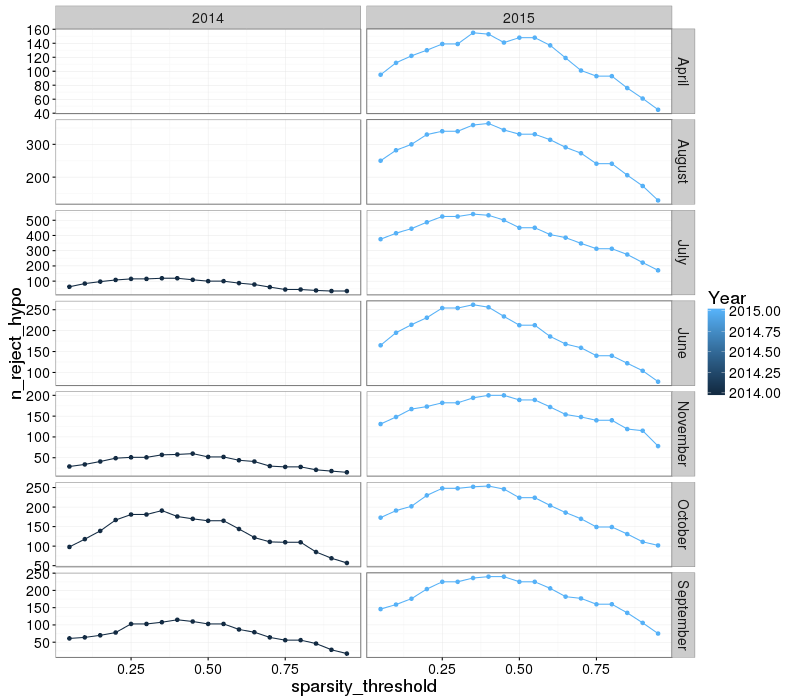

In [85]:
%%R -w 800 -h 700

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Year)) +
    geom_line(aes(color = Year)) +
    facet_grid(Month ~ Year, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

In [86]:
%%R
head(df.l2fc.rejH)

Source: local data frame [6 x 4]

  sparsity_threshold    Month  Year n_reject_hypo
               (dbl)   (fctr) (int)         (int)
1               0.05    April  2015            95
2               0.05   August  2015           250
3               0.05     July  2014            63
4               0.05     July  2015           376
5               0.05     June  2015           165
6               0.05 November  2014            29


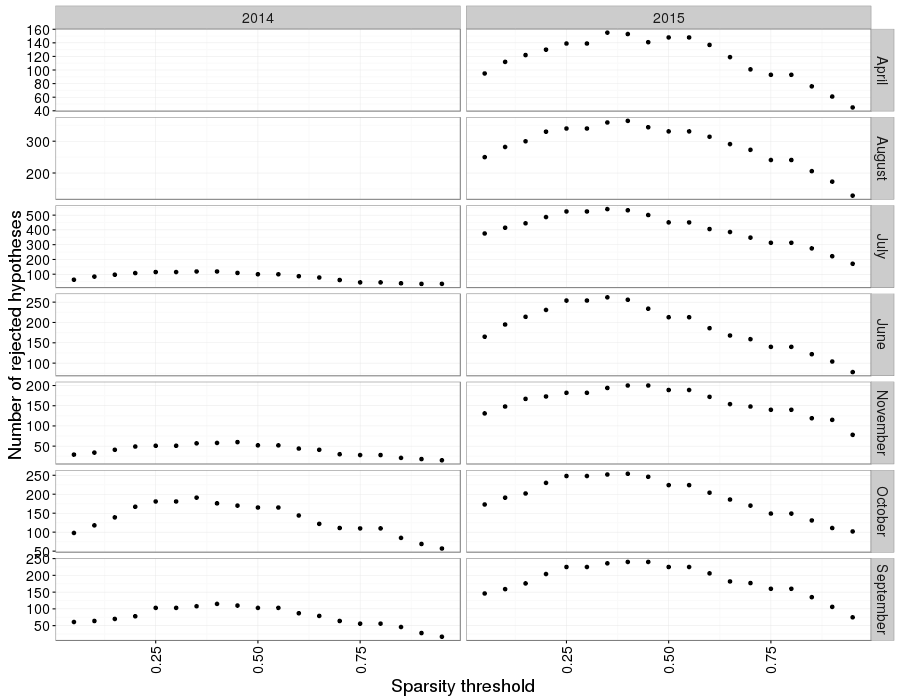

In [87]:
%%R -w 900 -h 700

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Month = as.character(Month))

df.l2fc.rejH$Month = reorder(df.l2fc.rejH$Month, df.l2fc.rejH$Month %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point() +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    facet_grid(Month ~ Year,scales = "free_y" ) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [88]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

  sparsity_threshold n_reject_hypo
1               0.05          1587
2               0.10          1802
3               0.15          1973


In [89]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.35


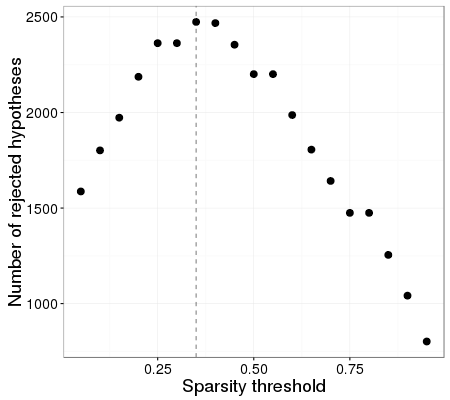

In [90]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [91]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) 

df.l2fc.f %>% nrow

[1] 53246


In [92]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_sparse-Till_noRarefy.txt'
write.table(df.l2fc.f, 'data/l2fc_sparse-Till_noRarefy.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [93]:
%%R
df.l2fc = read.table('data/l2fc_sparse-Till_noRarefy.txt', sep='\t', header = TRUE)

In [94]:
%%R
df.l2fc$Rank2 = gsub("__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("__", "", df.l2fc$Rank7)

In [95]:
%%R
df.l2fc$Month = factor(df.l2fc$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))


In [96]:
%%R
test = filter(df.l2fc, padj2<=0.10)
print(length(unique(test$OTU)))
print(length(unique(df.l2fc$OTU)))

[1] 912
[1] 7535


In [97]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Month, Year, Till) %>% summarise(resp = n())
resp %>% as.data.frame
resp$treat = "a"

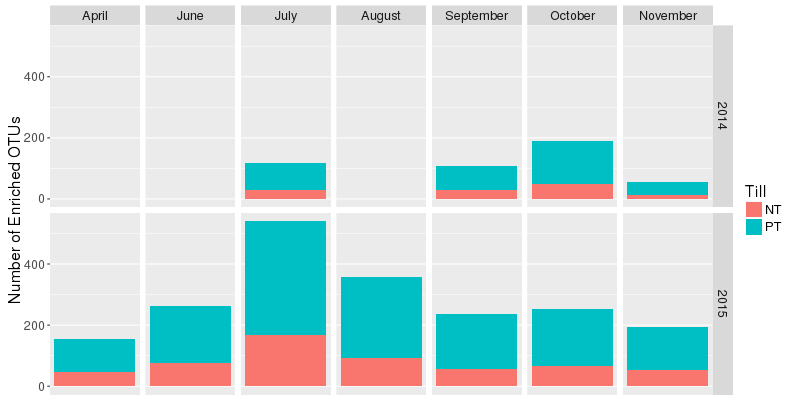

In [98]:
%%R -w 800 -h 400
p = ggplot(data = resp, aes(x = treat, y = resp)) +
    geom_bar(stat = 'identity', aes(fill = Till), position = 'stack') + facet_grid(Year~Month, scales = 'fixed')+
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") + scale_x_discrete(breaks=NULL) + xlab(NULL)
p

In [99]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

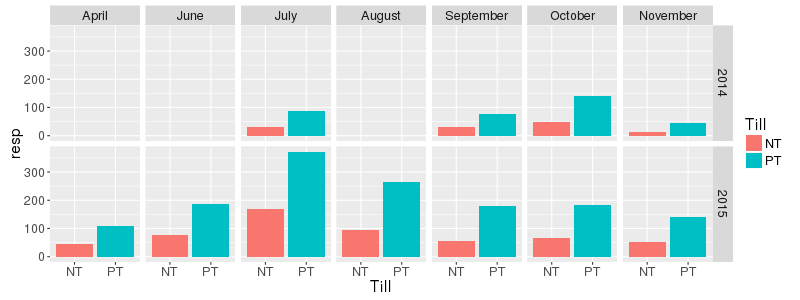

In [100]:
%%R -w 800 -h 300
ggplot(data = resp, aes(x = Till, y = resp, fill = Till)) +
    geom_bar(stat = 'identity') + facet_grid(Year~Month) +
    theme(text = element_text(size=16))

####Function arguments

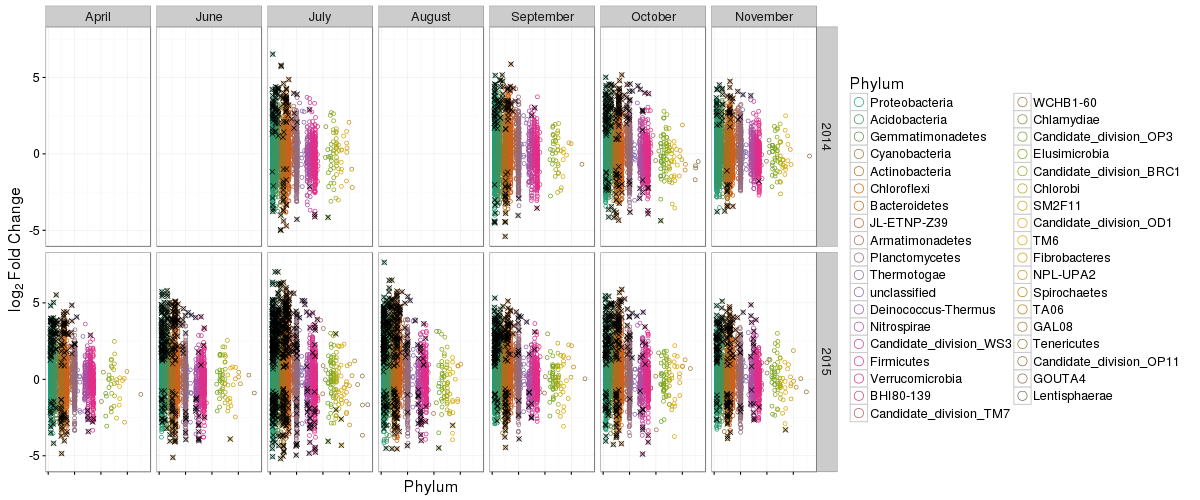

In [101]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= 0.10), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

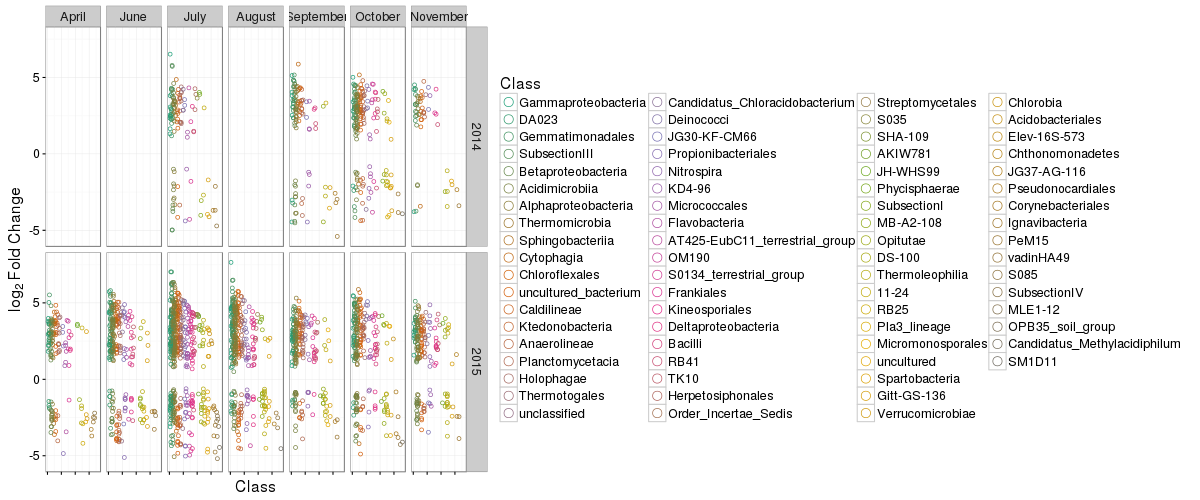

In [102]:
%%R -w 1200 -h 500
FDR = 0.10
d = filter(df.l2fc, padj2 <= FDR) 


d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))
p = p + facet_grid(Year~Month)

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

#p = p + geom_point(data = subset(d, padj2 <= 0.05), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) #+ guides(color = FALSE)

p

In [103]:
%%R
re = filter(df.l2fc, padj2 <=0.10)
length(unique(re$OTU))

[1] 912


In [104]:
%%R
new_df.l2fc = df.l2fc

In [105]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

In [106]:
%%R
NT = filter(new_df.l2fc, Month == "November")
PT = filter(new_df.l2fc, Month == "November")
#length(unique(intersect(NT$OTU, PT$OTU)))
length((NT$OTU))

[1] 9411


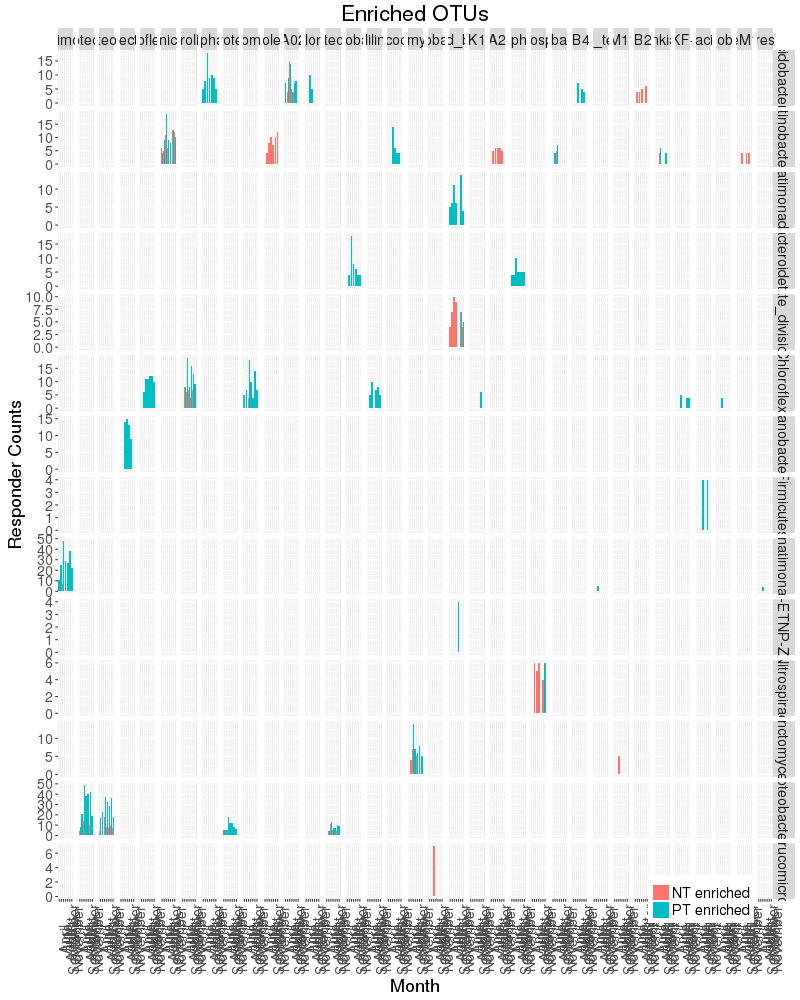

In [107]:
%%R -w 800 -h 1000
dcounts = new_df.l2fc %>%
          #filter(!is.na(log2FoldChange)) %>%
          #filter(!is.na(padj)) %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(Rank3, Rank2, Month, Resp_status) %>%
          summarize(responders = sum(padj<= 0.10)) %>%
          filter(responders > 3)
#dcounts = filter(dcounts, Rank2 %in% c("__Proteobacteria", "__Acidobacteria", "__Bacteroidetes", "__Planctomycetes", "__Chloroflexi", "__Actinobacteria", "__Verrucomicrobia", "__Gemmatimonadetes", "__Candidate_division_WS3", "__Cyanobacteria", "__Armatimonadetes", "__Firmicutes", "__Nitrospirae", "__Chlorobi"))
dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)
#newrow = c("__Firmicutes", "October", "PT enriched", as.numeric(0))
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "October", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Armatimonadetes", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
#newrow = c("__Cyanobacteria", "November", "PT enriched", 0)
#dcounts = rbind(dcounts,newrow)
dcounts$Rank3 <- droplevels(dcounts$Rank3)
dcounts$responders= as.numeric(dcounts$responders)
dcounts$Rank3 = reorder(dcounts$Rank3, -dcounts$responders)

p = ggplot(dcounts, aes(x = Month , y = responders, fill = Resp_status)) +
    geom_bar(stat = "identity", position="dodge") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_grid(Rank2 ~ Rank3, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Month") + guides(fill=guide_legend(title=NULL)) +
    theme(text = element_text(size=18), axis.text.x = element_text(angle=90, vjust=1), legend.position=c(.9, 0)) 


p

In [108]:
%%R
ggsave(filename = "figs/PTvsNT_phyla_wmonths.png", plot = p, width =16, height =8)


Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : 
  could not open file 'figs/PTvsNT_phyla_wmonths.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In (function (..., list = character(), package = NULL, lib.loc = NULL,  :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  data set ‘joined_df’ not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/r

In [109]:
%%R
dcounts = df.l2fc %>%
          filter(padj2 <=0.10) %>%
          group_by(Till, Rank5, Rank4, Rank3, Rank2, Month) %>%
          summarize(responders = sum(padj2<= 0.10))
head(dcounts)

Source: local data frame [6 x 7]
Groups: Till, Rank5, Rank4, Rank3, Rank2 [1]

    Till     Rank5         Rank4      Rank3       Rank2     Month responders
  (fctr)     (chr)         (chr)      (chr)       (chr)    (fctr)      (int)
1     NT 0319-6A21 Nitrospirales Nitrospira Nitrospirae      June          4
2     NT 0319-6A21 Nitrospirales Nitrospira Nitrospirae      July          2
3     NT 0319-6A21 Nitrospirales Nitrospira Nitrospirae    August          3
4     NT 0319-6A21 Nitrospirales Nitrospira Nitrospirae September          2
5     NT 0319-6A21 Nitrospirales Nitrospira Nitrospirae   October          3
6     NT 0319-6A21 Nitrospirales Nitrospira Nitrospirae  November          1


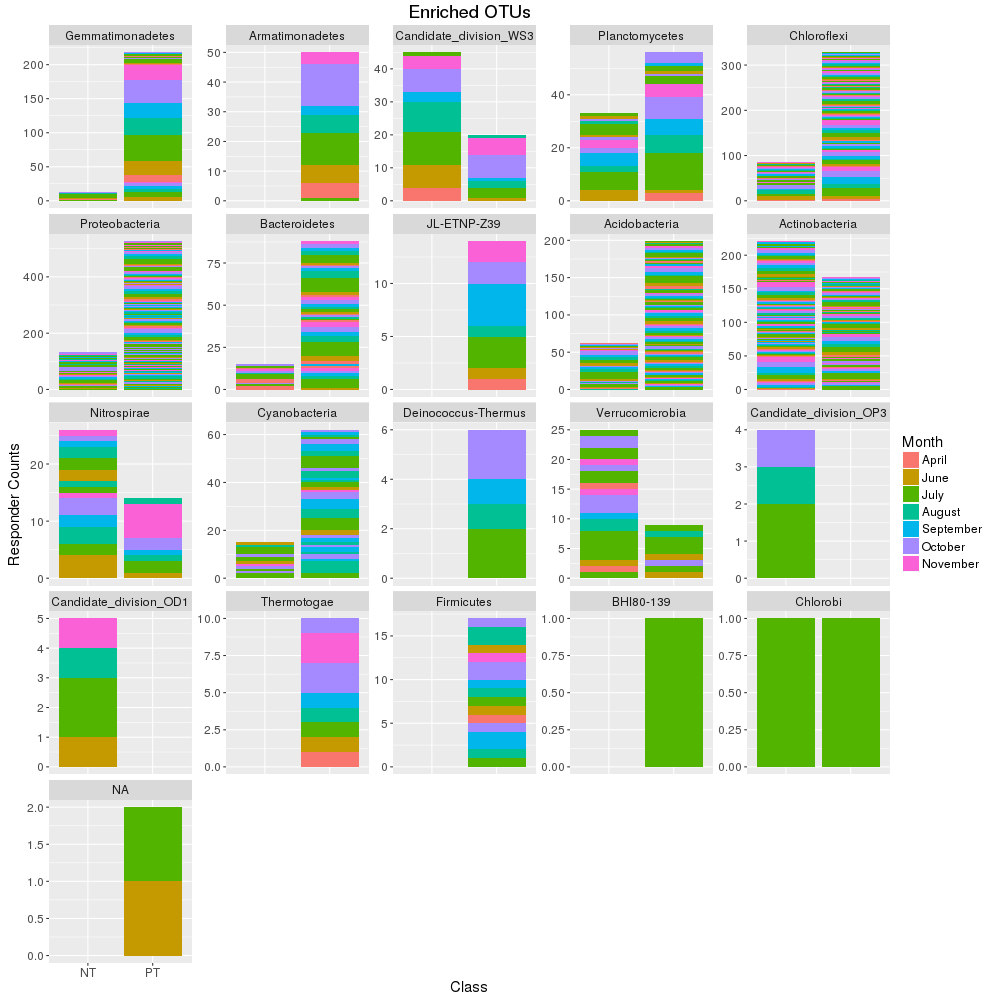

In [110]:
%%R -w 1000 -h 1000

dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)
dcounts$Rank4 = reorder(dcounts$Rank4, dcounts$Rank2)


p = ggplot(dcounts, aes(x = Till , y = responders, fill = Month)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap( ~ Rank2, scales = "free_y") + ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Class") + guides(fill=guide_legend(title="Month"))+
    theme(text = element_text(size=15))


p

In [111]:
%%R
filter(df.l2fc, Rank2 == 'Verrucomicrobia') %>% arrange(-padj2) %>% head()

  Month Year sparsity_threshold       OTU log2FoldChange     lfcSE      padj
1  July 2014               0.35  OTU.6205     -0.9538143 0.9391657 0.6044955
2  July 2014               0.35 OTU.16926     -0.8371862 0.8845201 0.6318984
3  July 2014               0.35 OTU.11424      1.8434819 0.9531176 0.2432220
4  July 2014               0.35  OTU.6619      0.5039023 0.9594172 0.8213523
5  July 2014               0.35 OTU.19530     -0.8973457 0.7951433 0.5623132
6  July 2014               0.35 OTU.11405     -0.2880658 0.8915549 0.8942548
     Rank1           Rank2    Rank3      Rank4                Rank5    Rank6
1 Bacteria Verrucomicrobia Opitutae  vadinHA64 uncultured_bacterium     <NA>
2 Bacteria Verrucomicrobia Opitutae Opitutales          Opitutaceae Opitutus
3 Bacteria Verrucomicrobia Opitutae Opitutales          Opitutaceae Opitutus
4 Bacteria Verrucomicrobia Opitutae Opitutales          Opitutaceae Opitutus
5 Bacteria Verrucomicrobia Opitutae Opitutales          Opitutaceae Opitutus

In [112]:
%%R
ggsave(filename = "figs/PTvsNT_phyla.png", plot = p, width =14, height =14)


Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/PTvsNT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 50 or more warnings (use warnings() to see the first 50)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


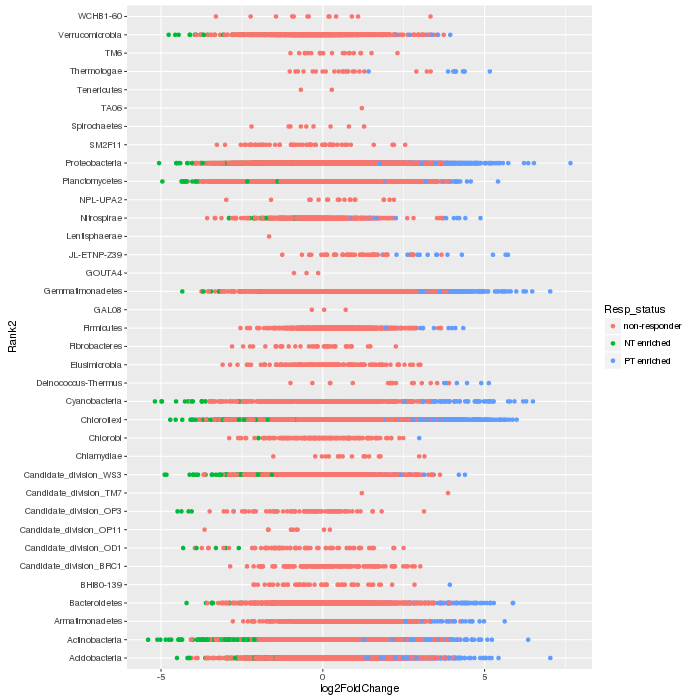

In [113]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

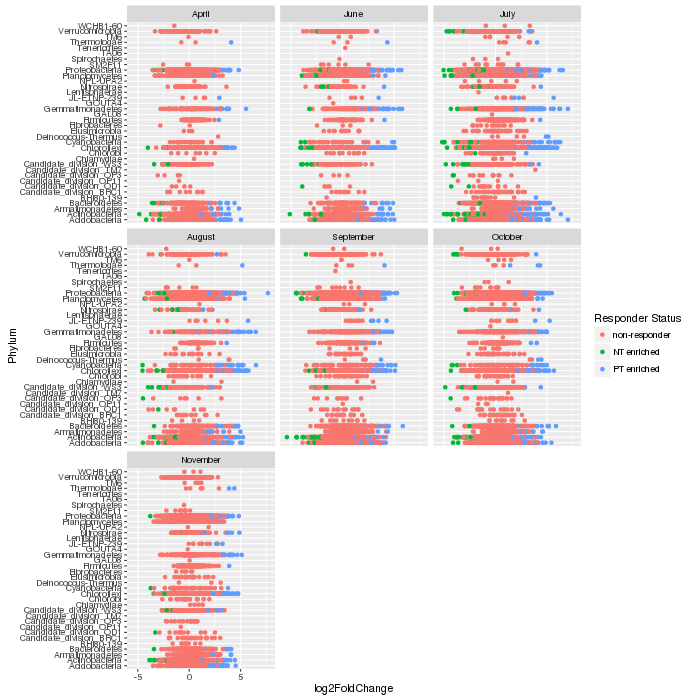

In [114]:
%%R -w 700 -h 700
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

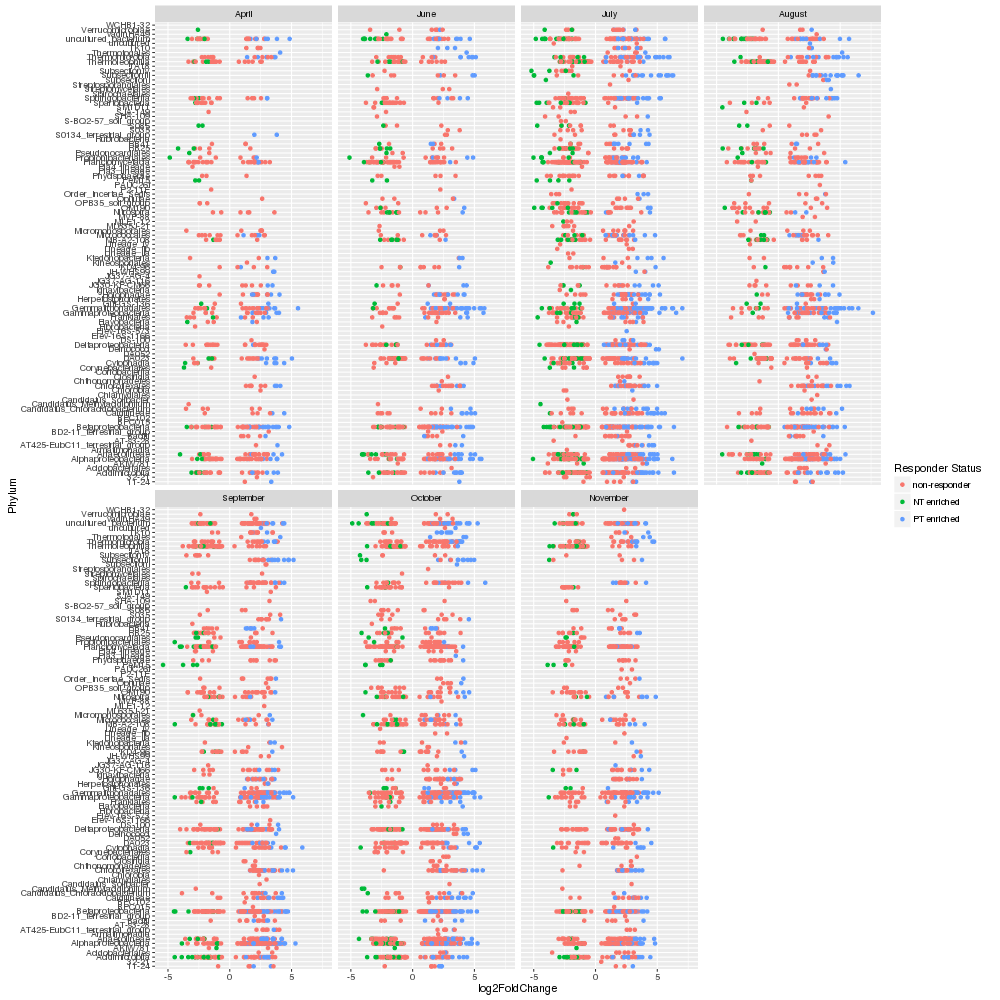

In [115]:
%%R -w 1000 -h 1000
new_df.l2fc_2 = filter(new_df.l2fc, padj <=0.10)
p = ggplot(new_df.l2fc_2, aes(log2FoldChange, Rank3))
p = p + geom_point(aes(color = Resp_status))
p = p + facet_wrap(~Month, ncol = 4)
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum")
p

In [116]:
%%R
ggsave(filename = "figs/NT_PT_phyla.png", plot = p, width =10, height =3)


Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in grid.newpage() : could not open file 'figs/NT_PT_phyla.png'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 71 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 71 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 3: Removed 40 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [117]:
%%R -w 700 -h 700
July = filter(new_df.l2fc, Month == "July") %>%
        group_by(OTU) 
Sept = filter(new_df.l2fc, Month == "September")%>%
        group_by(OTU)
JS2 = right_join(July, Sept, by = "OTU")

In [118]:
%%R
JS2$Resp_status[JS2$padj.x > 0.10 & JS2$padj.y >0.10] = "unknown/non-responder"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "NT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "PT responder both"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x > 0 & JS2$padj.y > 0.10] = "PT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y > 0] = "PT responder Sept"
JS2$Resp_status[JS2$padj.x <= 0.10 & JS2$log2FoldChange.x < 0 & JS2$padj.y < 0.10] = "NT responder July"
JS2$Resp_status[JS2$padj.x > 0.10  & JS2$padj.y <= 0.10 & JS2$log2FoldChange.y < 0] = "NT responder Sept"

In [119]:
%%R
head(JS2)

Source: local data frame [6 x 36]
Groups: OTU [4]

  Month.x Year.x sparsity_threshold.x       OTU log2FoldChange.x   lfcSE.x
   (fctr)  (int)                (dbl)    (fctr)            (dbl)     (dbl)
1    July   2014                 0.35  OTU.1813       -1.2958700 0.9196185
2    July   2015                 0.35  OTU.1813       -1.7126817 0.7666369
3    July   2014                 0.35   OTU.778       -1.0941587 0.4096504
4    July   2015                 0.35   OTU.778       -0.1861223 0.2977571
5      NA     NA                   NA  OTU.5511               NA        NA
6      NA     NA                   NA OTU.17812               NA        NA
Variables not shown: padj.x (dbl), Rank1.x (fctr), Rank2.x (chr), Rank3.x
  (chr), Rank4.x (chr), Rank5.x (chr), Rank6.x (chr), Rank7.x (chr), Rank8.x
  (fctr), padj2.x (dbl), Till.x (fctr), Resp_status.x (chr), Month.y (fctr),
  Year.y (int), sparsity_threshold.y (dbl), log2FoldChange.y (dbl), lfcSE.y
  (dbl), padj.y (dbl), Rank1.y (fctr), Rank2.

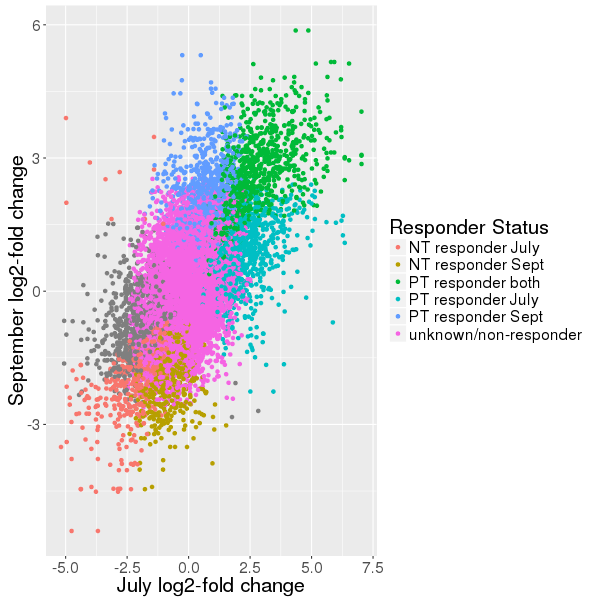

In [120]:
%%R -w 600 -h 600
p = ggplot(JS2, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

In [121]:
%%R
Sept = filter(new_df.l2fc, Month == "September") %>%
        group_by(OTU) 
Oct = filter(new_df.l2fc, Month == "October")%>%
        group_by(OTU)
SO = right_join(Sept, Oct, by = "OTU")

In [122]:
%%R
SO$Resp_status[SO$padj.x > 0.10 & SO$padj.y >0.10] = "unknown/non-responder"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "NT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "PT responder both"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x > 0 & SO$padj.y > 0.10] = "PT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y > 0] = "PT responder Oct"
SO$Resp_status[SO$padj.x <= 0.10 & SO$log2FoldChange.x < 0 & SO$padj.y > 0.10] = "NT responder Sept"
SO$Resp_status[SO$padj.x > 0.10  & SO$padj.y <= 0.10 & SO$log2FoldChange.y < 0] = "NT responder Oct"

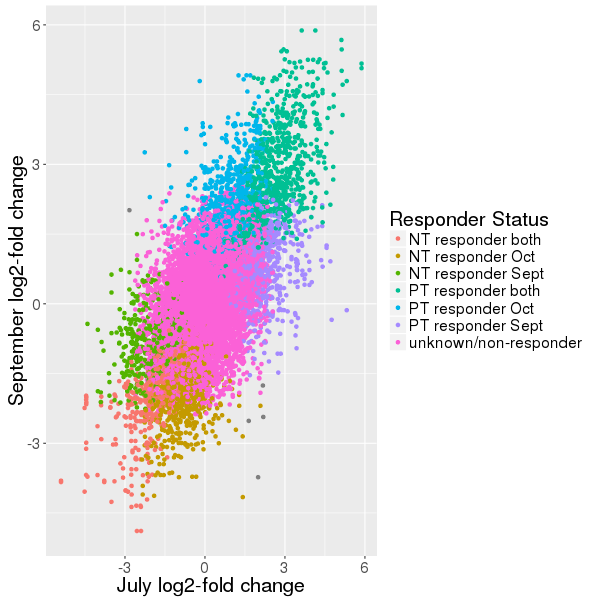

In [123]:
%%R -w 600 -h 600
p = ggplot(SO, aes(log2FoldChange.x, log2FoldChange.y))
p = p + geom_point(aes(color = Resp_status))
p = p + xlab("July log2-fold change") + ylab("September log2-fold change")
p = p + scale_colour_discrete(name="Responder Status")
p = p + theme(text=element_text(size = 20))
p

## Blasting against Living Tree Project db

In [124]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [125]:
from cogent import LoadSeqs, DNA


In [126]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

>OTU.162
TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCTGTGAAATCTGGGGGCTCAACCCCCAGCCTGCAGTGGGTACGGGCAGACTAGAGTGCGGTAGGGGAGATTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGATCTCTGGGCCGTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCATGCCGTAAACGTTGGGAACTAGATGTGGGGACCATTCCACGGTCTCCGTGTCGCAGCTAACGCATTAAGTTCCCCGCCTGGGGAGTACGGCCGCAAGGCTA
>OTU.239
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATAGCCTTTAAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGATAACTAGCTGTCTGGGTGCTTGGCACTTAGGTGGCGCAGCTAACGCATTAAGTTATCCGCCTGGGGAGTACGGTCGCAAGATTA
>OTU.2456
TACGGAGGGTGCAAGCGTTATCCGGATTCACTGGGTTTAAAGGGTGCGTAGGCGGGCATATAAGTCAGTGGTGAAATCCCCGAGCTTAACTTGGGAACTGCCATTGATACTATGTGTCTTGAATATCGCGGAGGTAAGCGGAATATGTCATGTAGCGGTGAAATGCATAGATATGACATAGAACACCGATTGCGAAGGCAGCTTACTACACGATCATTGACG

In [127]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [128]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

blastn -out otusn_silvaRefNR115.m6 -outfmt 6 -query seqs.fasta -db /var/seq_data/silva/silva_blastdb/silva_RefNR_115 -num_threads 5


('', '')

In [129]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

OTU.162	HQ256829	100.00	375	0	0	1	375	445	819	0.0	  693
3000 otusn_silvaRefNR115.m6
500


In [130]:
from IPython.display import Image
import pandas.rpy.common as com

In [131]:
%%R
library(data.table)
library(dplyr)

In [132]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))


Error in eval(expr, envir, enclos) : 
  error in evaluating the argument 'x' in selecting a method for function 'rank': Error in (function (classes, fdef, mtable)  : 
  unable to find an inherited method for function ‘desc’ for signature ‘"integer"’


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: Removed 425 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: Removed 867 rows containing missing values (geom_point). 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [133]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)


Error in head(top_hits_df_LTP) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': Error: object 'top_hits_df_LTP' not found


In [134]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [135]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)


Error in left_join(top_hits_df_LTP, LTP_seq_data) : 
  object 'top_hits_df_LTP' not found


In [136]:
%%R
joined_df = filter(joined_df, name != "NA")


Error in filter_(.data, .dots = lazyeval::lazy_dots(...)) : 
  object 'joined_df' not found


In [137]:
%%R
dim(joined_df)


Error in withVisible({ : object 'joined_df' not found


In [138]:
df = com.load_data("joined_df")

LookupError: 'joined_df' not found

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")